In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import SGDClassifier, Lasso, LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)


Обязательные

1. Провести первичный анализ данных

2. На большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов.

3. Применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в sklearn.decomposition.pca.components_ после построения главных компонент).

4. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация). Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. 

Метрика оценки качества — ROC AUC.
Обязательное

1. На том же наборе данных, что и в предыдущем задании, провести feature engineering:

создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
cделать one hot encoding там, где необходимо
по желанию посчитать каунты (counts)
2. Обучить linear SVM и SVM с нелинейным ядром — сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег).


 

In [2]:
init_df = pd.read_csv('../input/bankfullcsv/bank-full.csv')

In [3]:
init_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
init_df.drop(['duration'], axis=1, inplace=True)
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  Target     45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


In [5]:

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer


init_df.Target = LabelBinarizer().fit_transform(init_df.Target)
init_df.housing = LabelBinarizer().fit_transform(init_df.housing)
init_df.loan = LabelBinarizer().fit_transform(init_df.loan)
init_df.default = LabelBinarizer().fit_transform(init_df.default)


init_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,4,-1,0,unknown,0


In [6]:
cor = init_df.corr()
cor.Target

age         0.025155
default    -0.022419
balance     0.052838
housing    -0.139173
loan       -0.068185
day        -0.028348
campaign   -0.073172
pdays       0.103621
previous    0.093236
Target      1.000000
Name: Target, dtype: float64

<AxesSubplot:>

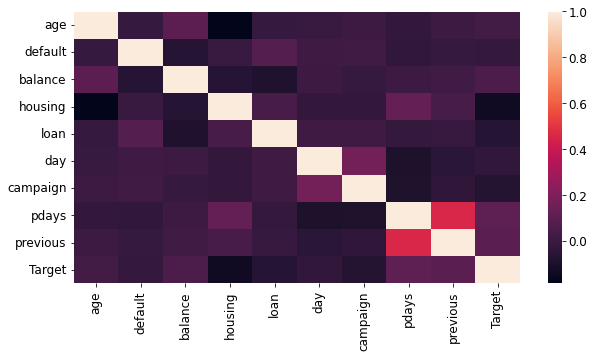

In [7]:
sns.heatmap(cor)

## Let's create function for features with a lot of categories that apply Weights of Evidence method to this features and separate dataset to test and train part

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
X = init_df.drop(['Target'], axis=1)
y = init_df.Target

for train_size, test_size in split.split(X, y):
    X_train = X.iloc[train_size]
    X_test = X.iloc[test_size]
    
    y_train = y.iloc[train_size]
    y_test = y.iloc[test_size]


In [9]:
both_train = pd.concat([X_train, y_train], axis=1, ignore_index=True)
both_train.columns = init_df.columns

both_test = pd.concat([X_test, y_test], axis=1, ignore_index=True)
both_test.columns = init_df.columns
both_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
21093,59,retired,married,primary,0,46,0,0,cellular,14,aug,2,-1,0,unknown,0
14143,30,blue-collar,married,primary,0,35,1,0,cellular,11,jul,2,-1,0,unknown,0
44689,48,management,married,tertiary,0,0,1,0,cellular,6,sep,2,125,6,failure,1
39081,33,technician,single,unknown,0,135,1,0,cellular,18,may,1,-1,0,unknown,0
30425,47,technician,single,secondary,0,58,0,0,telephone,5,feb,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,housemaid,married,primary,0,3376,0,0,unknown,9,jun,3,-1,0,unknown,0
25954,32,admin.,married,secondary,0,269,1,0,cellular,19,nov,1,-1,0,unknown,0
31119,68,retired,married,secondary,0,445,0,0,cellular,18,feb,1,-1,0,unknown,1
43278,54,management,divorced,tertiary,0,7010,0,0,cellular,11,mar,2,-1,0,unknown,0


In [10]:
def woe(df_train, df_test, col, target):
    all_good = len(df_train[df_train[target]==1][col])
    all_bad = len(df_train[df_train[target]==0][col])
    odds = (df_train[df_train[target]==1][col].value_counts()
            /df_train[df_train[target]==0][col].value_counts())
    odds = odds/all_good * all_bad
    dict_for_apply = np.log(odds).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(dict_for_apply.get)
    df_test[col + '_woe'] = df_test[col].apply(dict_for_apply.get)
    
    return df_train, df_test

In [11]:
columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'day', 'month']
for i in columns:
    woe(both_train, both_test, i, 'Target')

In [12]:
both_train.drop(['job', 'marital', 'education', 'contact', 'poutcome', 'day', 'month'], axis=1, inplace=True)


In [13]:
both_test.drop(['job', 'marital', 'education', 'contact', 'poutcome', 'day', 'month'], axis=1, inplace=True)

In [14]:
both_train

,age,default,balance,housing,loan,campaign,pdays,previous,Target,job_woe,marital_woe,education_woe,contact_woe,poutcome_woe,day_woe,month_woe
21093,59,0,46,0,0,2,-1,0,0,0.779069,-0.165633,-0.336073,0.281316,-0.283603,0.019534,-0.079683
14143,30,0,35,1,0,2,-1,0,0,-0.507850,-0.165633,-0.336073,0.281316,-0.283603,-0.102432,-0.258520
44689,48,0,0,1,0,2,125,6,1,0.182024,-0.165633,0.287563,0.281316,0.131189,-0.353541,1.943277
39081,33,0,135,1,0,1,-1,0,0,-0.030517,0.290370,0.178833,0.281316,-0.283603,-0.209689,-0.628561
30425,47,0,58,0,0,1,-1,0,0,-0.030517,0.290370,-0.117291,0.095496,-0.283603,-0.094230,0.385137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,0,3376,0,0,3,-1,0,0,-0.282518,-0.165633,-0.336073,-1.110356,-0.283603,-0.042588,-0.118402
25954,32,0,269,1,0,1,-1,0,0,0.052716,-0.165633,-0.117291,0.281316,-0.283603,-0.465294,-0.130956
31119,68,0,445,0,0,1,-1,0,1,0.779069,-0.165633,-0.117291,0.281316,-0.283603,-0.209689,0.385137
43278,54,0,7010,0,0,2,-1,0,0,0.182024,0.024811,0.287563,0.281316,-0.283603,-0.102432,2.063925


In [15]:
y_train_num = both_train.Target
X_train_num = both_train.drop(['Target'], axis=1)

y_test_num = both_test.Target
X_test_num = both_test.drop(['Target'], axis=1)

In [16]:
X_train_num

,age,default,balance,housing,loan,campaign,pdays,previous,job_woe,marital_woe,education_woe,contact_woe,poutcome_woe,day_woe,month_woe
21093,59,0,46,0,0,2,-1,0,0.779069,-0.165633,-0.336073,0.281316,-0.283603,0.019534,-0.079683
14143,30,0,35,1,0,2,-1,0,-0.507850,-0.165633,-0.336073,0.281316,-0.283603,-0.102432,-0.258520
44689,48,0,0,1,0,2,125,6,0.182024,-0.165633,0.287563,0.281316,0.131189,-0.353541,1.943277
39081,33,0,135,1,0,1,-1,0,-0.030517,0.290370,0.178833,0.281316,-0.283603,-0.209689,-0.628561
30425,47,0,58,0,0,1,-1,0,-0.030517,0.290370,-0.117291,0.095496,-0.283603,-0.094230,0.385137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,0,3376,0,0,3,-1,0,-0.282518,-0.165633,-0.336073,-1.110356,-0.283603,-0.042588,-0.118402
25954,32,0,269,1,0,1,-1,0,0.052716,-0.165633,-0.117291,0.281316,-0.283603,-0.465294,-0.130956
31119,68,0,445,0,0,1,-1,0,0.779069,-0.165633,-0.117291,0.281316,-0.283603,-0.209689,0.385137
43278,54,0,7010,0,0,2,-1,0,0.182024,0.024811,0.287563,0.281316,-0.283603,-0.102432,2.063925


In [17]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num, y_train_num), columns = X_train_num.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_num, y_test_num), columns = X_test_num.columns)

# Lasso

In [18]:
%time
clf_lasso = Lasso(alpha=0.001)
clf_lasso.fit(X_train_scaled, y_train_num)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


Lasso(alpha=0.001)

In [19]:
clf_lasso.coef_

array([-0.        , -0.        ,  0.00627659, -0.01482632, -0.01066111,
       -0.01186068, -0.0163754 , -0.00075831,  0.0127804 ,  0.01309466,
        0.00199404,  0.01212467,  0.08871421,  0.02108373,  0.04833926])

In [20]:
clf_lasso.feature_names_in_

array(['age', 'default', 'balance', 'housing', 'loan', 'campaign',
       'pdays', 'previous', 'job_woe', 'marital_woe', 'education_woe',
       'contact_woe', 'poutcome_woe', 'day_woe', 'month_woe'],
      dtype=object)

In [21]:
d = dict(zip(clf_lasso.coef_, clf_lasso.feature_names_in_))
d

{-0.0: 'default',
 0.006276585448092366: 'balance',
 -0.014826320741778108: 'housing',
 -0.010661108710709105: 'loan',
 -0.011860682317701834: 'campaign',
 -0.016375400007902687: 'pdays',
 -0.0007583134833790143: 'previous',
 0.012780397874977029: 'job_woe',
 0.013094661479225209: 'marital_woe',
 0.0019940438211147114: 'education_woe',
 0.012124674420933118: 'contact_woe',
 0.08871421161291909: 'poutcome_woe',
 0.021083734803567927: 'day_woe',
 0.048339257386331325: 'month_woe'}

In [22]:
from sklearn.metrics import roc_curve, auc
def roc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_value = auc(fpr, tpr)
    if prin:
        print(f'AUC: {auc_value}')
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel = 'FPR'
        plt.ylabel = 'TPR'
    return auc_value 

TRAIN
AUC: 0.7549719682648222
TEST
AUC: 0.7635155209004615


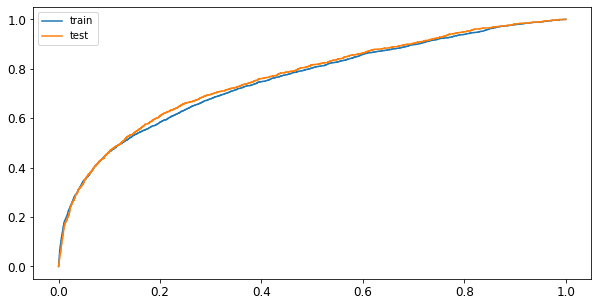

In [23]:
y_pred_test_lasso= clf_lasso.predict(X_test_scaled)
y_pred_train_lasso= clf_lasso.predict(X_train_scaled)
print('TRAIN')
roc_auc(y_train_num, y_pred_train_lasso, 'train')
print("TEST")
roc_auc(y_test_num, y_pred_test_lasso, 'test')
plt.legend()

# PCA

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=15)
X_pca = pca.fit(X_train_scaled)

In [26]:
X_pca.explained_variance_ratio_


array([0.14939832, 0.11122764, 0.09891214, 0.07566317, 0.0706872 ,
       0.06507459, 0.0628102 , 0.06152998, 0.05983692, 0.05175788,
       0.04440408, 0.04366811, 0.04263699, 0.03309244, 0.02930036])

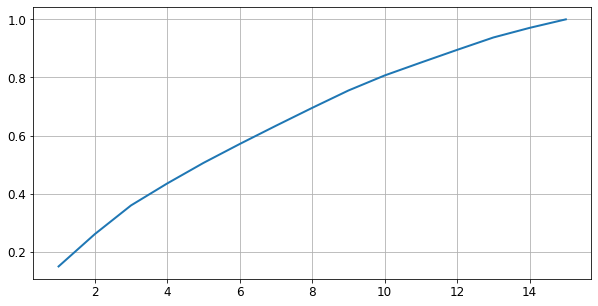

In [27]:
cum_evr = np.cumsum(X_pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()


## there is no obvious approximation of the curve at any value, so we rather will take all the complonents

# LogisticRegression

In [28]:
%time
clf_log = LogisticRegression()
clf_log.fit(X_train_scaled, y_train_num)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


LogisticRegression()

TRAIN
AUC: 0.7631934361303785
TEST
AUC: 0.7753190990566408


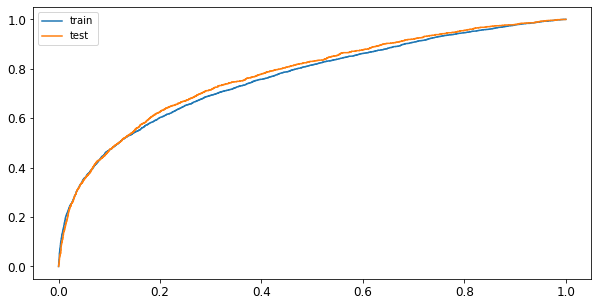

In [29]:
y_pred_test_log= clf_log.predict_proba(X_test_scaled)[:,1]
y_pred_train_log= clf_log.predict_proba(X_train_scaled)[:,1]
print('TRAIN')
roc_auc(y_train_num, y_pred_train_log, 'train')
print("TEST")
roc_auc(y_test_num, y_pred_test_log, 'test')
plt.legend()

# Support Vector Machine without Kernel trick - Linear Support Vector Classification

In [30]:
%time
clf_lin_svc = LinearSVC(C=100)
clf_lin_svc.fit(X_train_scaled, y_train_num)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=100)

TRAIN
AUC: 0.6325749989922901
TEST
AUC: 0.629918328550221


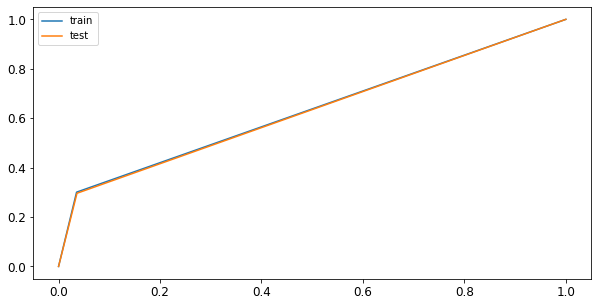

In [31]:
y_pred_test_linsvc= clf_lin_svc.predict(X_test_scaled)
y_pred_train_linsvc= clf_lin_svc.predict(X_train_scaled)
print('TRAIN')
roc_auc(y_train_num, y_pred_train_linsvc, 'train')
print("TEST")
roc_auc(y_test_num, y_pred_test_linsvc, 'test')
plt.legend()

# Support Vector Machine with kernel trick - SVC

In [32]:
%time
clf_svc = SVC()
clf_svc.fit(X_train_scaled, y_train_num)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


SVC()

TRAIN
AUC: 0.5880623782592166
TEST
AUC: 0.5708819976789161


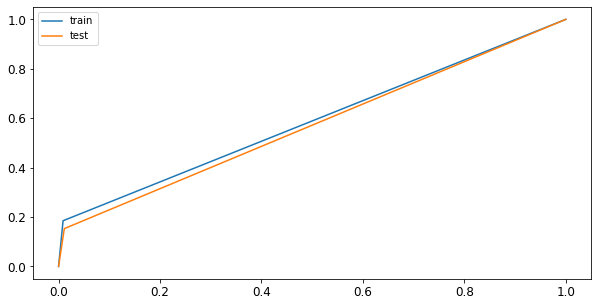

In [33]:
y_pred_test_svc= clf_svc.predict(X_test_scaled)
y_pred_train_svc= clf_svc.predict(X_train_scaled)
print('TRAIN')
roc_auc(y_train_num, y_pred_train_svc, 'train')
print("TEST")
roc_auc(y_test_num, y_pred_test_svc, 'test')
plt.legend()

In [34]:
import xgboost as xg
X_train_scaled

,age,default,balance,housing,loan,campaign,pdays,previous,job_woe,marital_woe,education_woe,contact_woe,poutcome_woe,day_woe,month_woe
0,1.702897,-0.134703,-0.426121,-1.122001,-0.436306,-0.250318,-0.411488,-0.237134,2.258927,-0.748156,-1.424794,0.660389,-0.312198,0.188106,0.084257
1,-1.031266,-0.134703,-0.429693,0.891265,-0.436306,-0.250318,-0.411488,-0.237134,-1.233384,-0.748156,-1.424794,0.660389,-0.312198,-0.172063,-0.236311
2,0.665801,-0.134703,-0.441060,0.891265,-0.436306,-0.250318,0.846084,2.236358,0.638725,-0.748156,1.378503,0.660389,0.446171,-0.913593,3.710459
3,-0.748422,-0.134703,-0.397215,0.891265,-0.436306,-0.571339,-0.411488,-0.237134,0.061952,1.527486,0.889755,0.660389,-0.312198,-0.488797,-0.899619
4,0.571519,-0.134703,-0.422223,-1.122001,-0.436306,-0.571339,-0.411488,-0.237134,0.061952,1.527486,-0.441347,0.362747,-0.312198,-0.147843,0.917458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,0.760082,-0.134703,0.655389,-1.122001,-0.436306,0.070702,-0.411488,-0.237134,-0.621902,-0.748156,-1.424794,-1.568752,-0.312198,0.004657,0.014853
31643,-0.842703,-0.134703,-0.353695,0.891265,-0.436306,-0.571339,-0.411488,-0.237134,0.287822,-0.748156,-0.441347,0.660389,-0.312198,-1.243605,-0.007651
31644,2.551430,-0.134703,-0.296534,-1.122001,-0.436306,-0.571339,-0.411488,-0.237134,2.258927,-0.748156,-0.441347,0.660389,-0.312198,-0.488797,0.917458
31645,1.231489,-0.134703,1.835631,-1.122001,-0.436306,-0.250318,-0.411488,-0.237134,0.638725,0.202239,1.378503,0.660389,-0.312198,-0.172063,3.926724


In [35]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    clf_xgb = xg.XGBClassifier(**params)
    clf_xgb.fit(X_train_scaled, y_train)
    y_pred_test_xgb = clf_xgb.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc(y_test, y_pred_test_xgb, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print(f'{auc}')
    return result

space = {'max_depth': hp.quniform('max_depth', 1, 10, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'silent': 1,
        'n_estimators': 50, 
        'learning_rate': 0.01,
         }

In [36]:
trials = Trials()

In [37]:
best = fmin(score, space, algo = tpe.suggest, trials=trials, max_evals=20)

[14:35:48] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.777206064827361
[14:35:48] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.7470482308061677
[14:35:49] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter

In [38]:
trials.best_trial

{'state': 2,
 'tid': 10,
 'spec': None,
 'result': {'loss': 0.20140932270994738, 'status': 'ok'},
 'misc': {'tid': 10,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [10],
   'gamma': [10],
   'max_depth': [10],
   'min_child_weight': [10],
   'subsample': [10]},
  'vals': {'colsample_bytree': [0.55],
   'gamma': [0.65],
   'max_depth': [9.0],
   'min_child_weight': [8.0],
   'subsample': [0.8500000000000001]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 11, 18, 14, 35, 56, 797000),
 'refresh_time': datetime.datetime(2022, 11, 18, 14, 35, 58, 2000)}